# Gaussian Cookbook

### Simulating the Brownian bridge via a discrete-time decomposition

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Discrete-Time Decomposition

In [25]:
def brownian_bridge_dtr(steps=100, paths=1, T=1):
    # Generate time points
    t = np.linspace(0, T, steps)
    # Initialize covariance matrix
    Gamma = np.zeros((steps, steps))
    # Autocovariance function - scale by T to make it work for arbitrary time horizons
    gamma = lambda s, t: T * (np.minimum(s/T, t/T) - (s/T) * (t/T))
    # Fill covariance matrix using min(s,t) function
    for i in range(steps):
        for j in range(steps):
            Gamma[i,j] = gamma(t[i], t[j])
    # Compute eigendecomposition
    eigenvals, eigenvecs = np.linalg.eigh(Gamma)
    # Remove any negative eigenvalues due to numerical error
    eigenvals = np.maximum(eigenvals, 0)
    # Generate standard normal random variables
    Z = np.random.normal(0, 1, (steps, paths))
    # Construct Brownian paths using eigendecomposition
    # W(t) = Q Λ^(1/2) Z where Q are eigenvectors and Λ are eigenvalues
    Bt = eigenvecs @ np.diag(np.sqrt(eigenvals)) @ Z
    return Bt.T

### Sample paths of Brownian motion

Brownian bridge paths are generated via a discretization of the continuous-time decomposition (`brownian_bridge_ctr`).

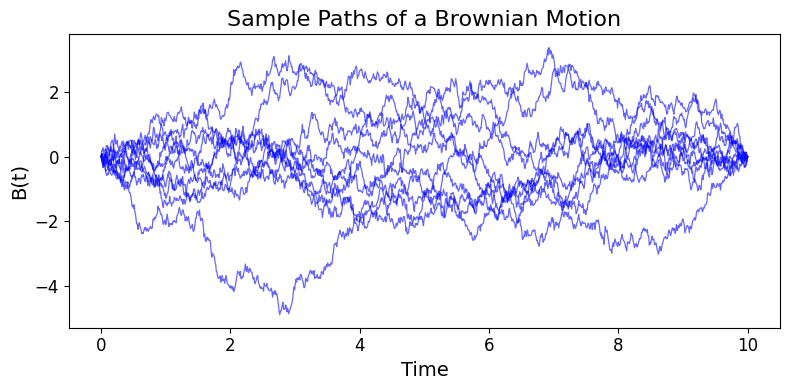

In [29]:
# Set random seed for reproducibility
np.random.seed(14)

# Generate multiple paths
n_paths = 10
steps = 1000
paths = brownian_bridge_dtr(steps=steps, paths=n_paths, T=10)
t = np.linspace(0, 10, steps)

# Create figure with journal article styling
plt.figure(figsize=(8, 4))

# Plot each path
for i in range(n_paths):
    plt.plot(t, paths[i,:], color='blue', linewidth=0.9, alpha=0.6)

# Customize the plot
plt.xlabel('Time', fontsize=14)
plt.ylabel('B(t)', fontsize=14)
plt.title('Sample Paths of a Brownian Motion', fontsize=16)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Sample Covariance Converging to the Theoretical Covariance

Showing the convergence of the empirical covariance structure to the theoretical covariance structure as quantity of paths increase.

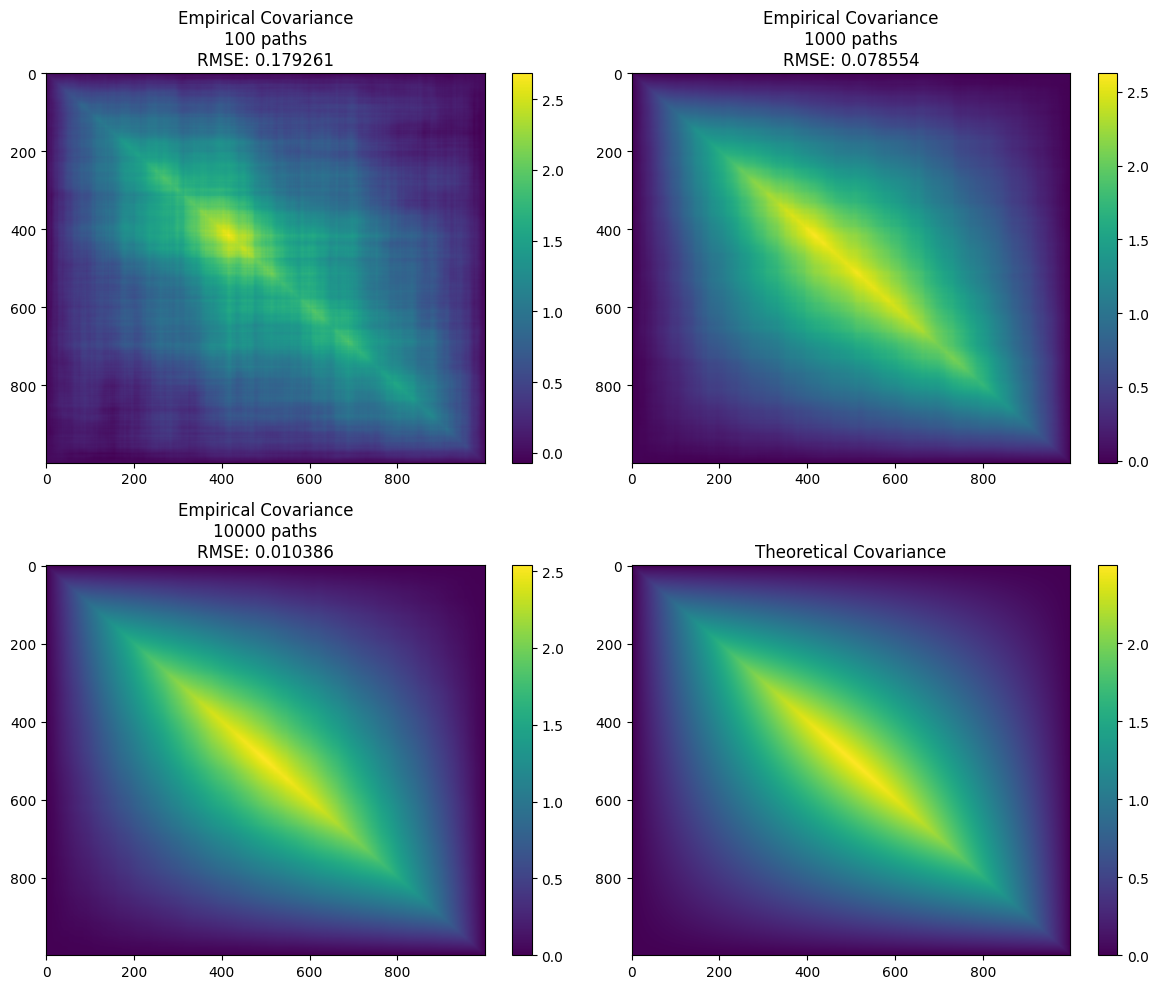

In [31]:
# Function to compute theoretical covariance
def theoretical_covariance(t1, t2, T=1):
    return np.minimum(t1, t2) - t1 * t2 / T

# Function to compute RMSE between matrices
def matrix_rmse(A, B):
    return np.sqrt(np.mean((A - B) ** 2))

# Create time points
t = np.linspace(0, 10, steps)
T1, T2 = np.meshgrid(t, t)
theoretical_cov = theoretical_covariance(T1, T2, T = 10)

# Create figure for heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Generate paths and plot covariance heatmaps for different sample sizes
path_counts = [100, 1000, 10000]
for idx, n_paths in enumerate(path_counts):
    # Generate paths
    paths = brownian_bridge_dtr(steps=steps, paths=n_paths, T = 10)
    
    # Compute empirical covariance
    empirical_cov = np.cov(paths.T)
    
    # Compute RMSE
    rmse = matrix_rmse(empirical_cov, theoretical_cov)
    
    # Plot heatmap
    im = axes[idx].imshow(empirical_cov, cmap='viridis', aspect='auto')
    axes[idx].set_title(f'Empirical Covariance\n{n_paths} paths\nRMSE: {rmse:.6f}')
    plt.colorbar(im, ax=axes[idx])

# Plot theoretical covariance
im = axes[3].imshow(theoretical_cov, cmap='viridis', aspect='auto')
axes[3].set_title('Theoretical Covariance')
plt.colorbar(im, ax=axes[3])

# Adjust layout
plt.tight_layout()
plt.show()

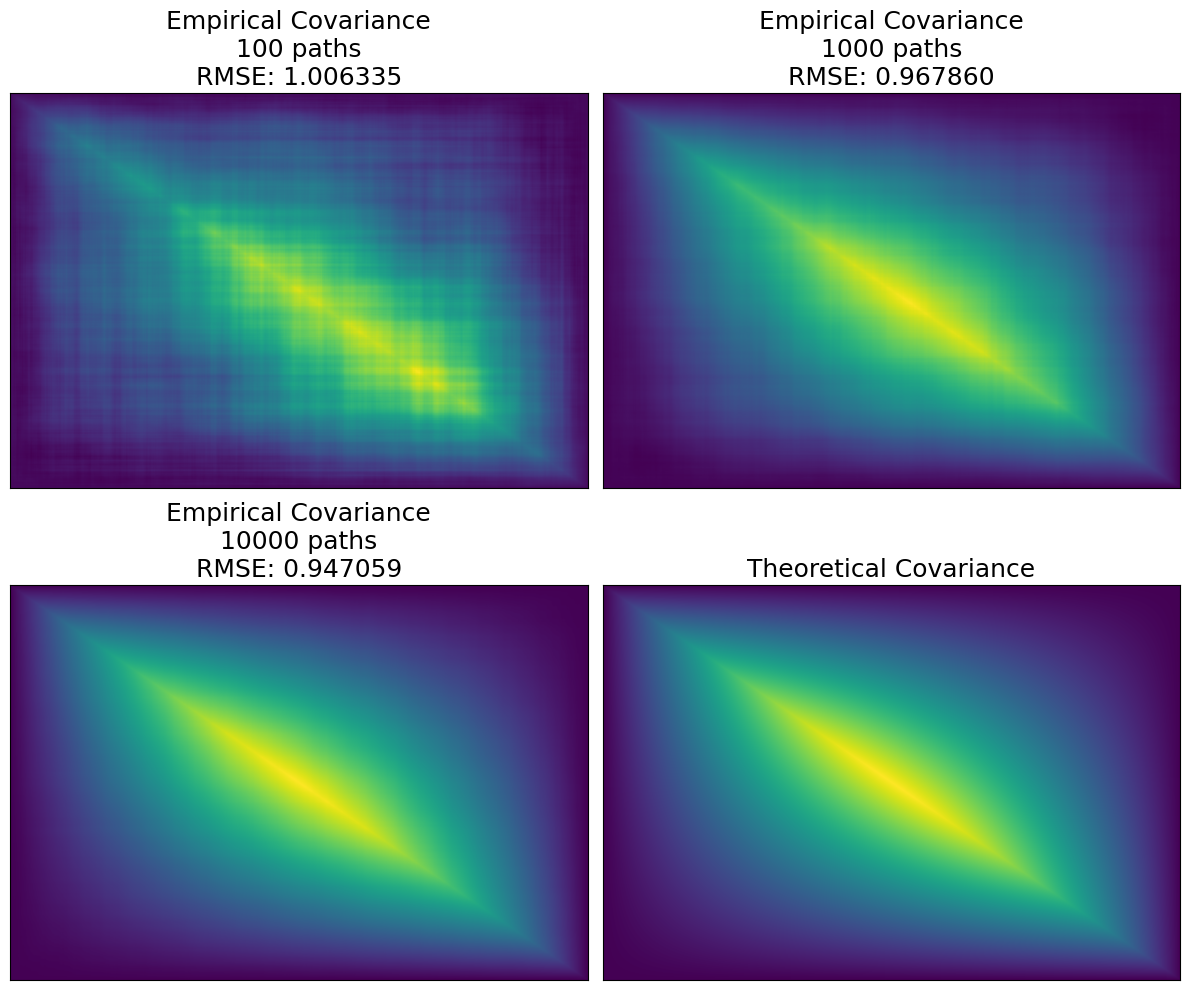

: 

In [32]:
# Create figure for heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Create time points
t = np.linspace(0, 1, steps)
T1, T2 = np.meshgrid(t, t)
theoretical_cov = theoretical_covariance(T1, T2)

# Generate paths and plot covariance heatmaps for different sample sizes
path_counts = [100, 1000, 10000]
for idx, n_paths in enumerate(path_counts):
    # Compute empirical covariance
    empirical_cov = np.cov(paths[:n_paths].T)
    
    # Compute RMSE
    rmse = matrix_rmse(empirical_cov, theoretical_cov)
    
    # Plot heatmap without ticks and colorbar
    im = axes[idx].imshow(empirical_cov, cmap='viridis', aspect='auto')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_title(f'Empirical Covariance\n{n_paths} paths\nRMSE: {rmse:.6f}', fontsize=18)

# Plot theoretical covariance
im = axes[3].imshow(theoretical_cov, cmap='viridis', aspect='auto')
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title('Theoretical Covariance', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.show()


### Empirical v. Theoretical Convergence of Empirical Covariance

The theoretical rate of convergence of the RMSE of empirical covariance relative to the empirical rate. 

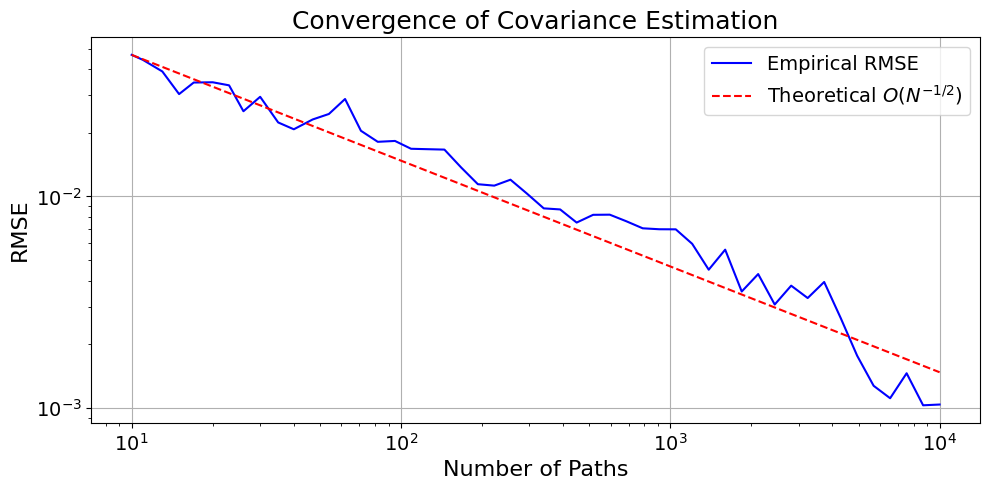

In [11]:
# Create figure for convergence plot
plt.figure(figsize=(10, 5))

# Calculate RMSE for different numbers of paths
path_counts = np.logspace(1, 4, 50, dtype=int)
rmse_values = []

for n in path_counts:
    empirical_cov = np.cov(paths[:n].T)
    rmse = matrix_rmse(empirical_cov, theoretical_cov)
    rmse_values.append(rmse)

# Plot empirical convergence
plt.loglog(path_counts, rmse_values, 'b-', label='Empirical RMSE')

# Plot theoretical N^(-1/2) convergence
theoretical_line = rmse_values[0] * np.sqrt(path_counts[0]/path_counts)
plt.loglog(path_counts, theoretical_line, 'r--', label='Theoretical $O(N^{-1/2})$')

plt.xlabel('Number of Paths', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.title('Convergence of Covariance Estimation', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()
